In [1]:
import types
import collections
import numpy as np
from random import shuffle
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.fn as fn
import nvidia.dali.types as types

batch_size = 16

In [2]:
class CelebAIterator(object):
    def __init__(self, batch_size, set_name: str='train'):
        self.images_dir = "/home/stasy/ssdb/celeba_manual/images/img_align_celeba/"
        self.batch_size = batch_size
        with open("/home/stasy/ssdb/celeba_manual/images/" + "list_eval_partition.txt", "r") as f:
            self.files = [line.rstrip() for line in f if line != ""]

        if set_name not in ["train", "val", "test"]:
            raise ValueError("set_name must be one of 'train', 'val', 'test'")
         
        set_int = {"train": 0, "val": 1, "test": 2}[set_name]
        self.files = [line.split(" ")[0] for line in self.files if line.split(" ")[1] == str(set_int)]
        print(f"Found {len(self.files)} images in {set_name} set")

        shuffle(self.files)

    def __iter__(self):
        self.i = 0
        self.n = len(self.files)
        return self


    @property
    def num_outputs(self):
        return 1
    
    def __next__(self):
        batch = []
        for _ in range(self.batch_size):
            jpeg_filename= self.files[self.i]
            f = open(self.images_dir + jpeg_filename, "rb")
            batch.append(np.frombuffer(f.read(), dtype=np.uint8))
            self.i = (self.i + 1) % self.n
        
        return (batch,)

In [3]:
train_set = CelebAIterator(batch_size, "train")

Found 162770 images in train set


In [4]:
pipe = Pipeline(batch_size=batch_size, num_threads=2, device_id=0)
with pipe:
    jpegs = fn.external_source(
        source=train_set, num_outputs=1, dtype=types.UINT8
    )
    decode = fn.decoders.image(jpegs, device="mixed")
    decode = fn.brightness_contrast(decode, contrast=2)
    decode = fn.resize(decode, resize_x=64, resize_y=64)
    decode = fn.crop_mirror_normalize(decode, dtype=types.FLOAT, std=[255., 255., 255.], mean=[0., 0., 0.])
    decode = fn.transpose(decode, perm=[1, 2, 0])
    pipe.set_outputs(decode)

In [5]:
pipe.build()
pipe_out = pipe.run()

In [6]:
batch_cpu = pipe_out[0].as_cpu()

(64, 64, 3)


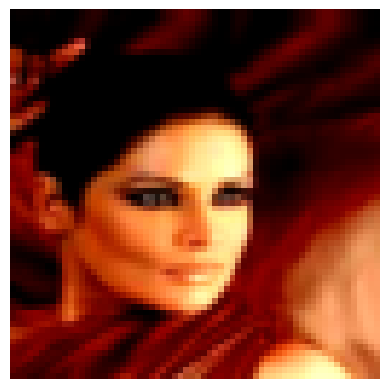

In [7]:
import matplotlib.pyplot as plt

img = batch_cpu.at(2)
print(img.shape)
plt.axis("off")
plt.imshow(img)